In [1]:
## Parameters specific to where your folders are and your data
parameter_file = '../parameters/params.yaml'
import yaml
import sys
import glob
with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
annotation= doc['annotation']
#annotation_gtf = doc['annotation_gtf']


import os

import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm
from os.path import basename, join
from Homer import *

print('Number of tissues: ',len(tissues))

import helper

from mplh.color_utils import get_colors
from mplh.fig_utils import legend_from_color

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  import sys


Number of tissues:  13


In [2]:
from matplotlib_venn import venn2

from tss.data import generate_genome
from tss.data.cumsum import *

params {'EMAIL': 'isshamie@ucsd.edu', 'parameters': 'parameters/params.yaml'}
/data2/resources/software/homer/v4.11_10242019/bin//


### Indir

In [3]:
f_in = 'analysis_ncbi_picr/tss_annotation/gene_df_02_tissues.p'
tissues_expression_f = "analysis_ncbi_picr/merged/tissues.merge.peaksexpression"

#Peak annotation
annoPeaks_f = join('analysis_ncbi_picr', 'merged','samples.merge.anno')
peaks_expr_f = join('analysis_ncbi_picr','merged','tissues.merge.peaksexpression')
peaks_with_distance_noCDS = 'analysis_ncbi_picr/merged/peaks_with_tss_distances_size1.noCDS.tsv'

### Outdir

In [4]:
os.chdir(doc["results"])
fig1_peaks = "figure1_summary"
if not os.path.exists(fig1_peaks):
    os.mkdir(fig1_peaks)
    
thresh=1
venn_f = join(fig1_peaks, f"peaks_venn_thresh{thresh}.csv")
cumulative_f = join(fig1_peaks, f"cumulative_peaks_thresh{thresh}.csv")

## Load

In [5]:
expr_df = pd.read_csv(tissues_expression_f,sep="\t",index_col = 0)

annoPeaks = pd.read_csv(annoPeaks_f,sep="\t",index_col=0)
annoPeaks = annoPeaks.dropna(subset=['Annotation'])
#annoPeaks = annoPeaks[annoPeaks["Annotation"].str.contains("promoter")]
annoPeaks

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type
PeakID (cmd=annotatePeaks.pl Results/merged/samples.merge /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3),,,,,,,,,,,,,,,,,,
539323,NW_020822460.1,1084630,1084782,+,66162.929688,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,promoter-TSS (ID=id200258;Parent=rna17072;Dbxr...,NaN,-1.0,ID=id200258;Parent=rna17072;Dbxref=GeneID:1138...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
353477,NW_020822618.1,401845,402000,-,21905.132812,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,promoter-TSS (ID=id559499;Parent=rna48773;Dbxr...,NaN,4.0,ID=id559499;Parent=rna48773;Dbxref=GeneID:1138...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,NW_020822410.1,4827637,4827815,+,20179.468750,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,promoter-TSS (ID=id67671;Parent=rna5683;Dbxref...,NaN,-11.0,ID=id67671;Parent=rna5683;Dbxref=GeneID:100756...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
349134,NW_020822505.1,689618,689773,-,18150.236328,f04_peaks/Brain_GROCap1_and_Brain_GRO1|f04_pea...,promoter-TSS (ID=id298638;Parent=rna25827;Dbxr...,NaN,3.0,ID=id298639;Parent=rna25828;Dbxref=GeneID:1138...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300005,NW_020822602.1,9283364,9283514,+,15297.872070,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,promoter-TSS (ID=id489748;Parent=rna42896;Dbxr...,NaN,0.0,ID=id489748;Parent=rna42896;Dbxref=GeneID:1138...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289272,NW_020822370.1,10486847,10486997,+,0.299000,f04_peaks/CHO_START1_and_CHO_startinput1,Intergenic,NaN,-6013.0,ID=id6288;Parent=rna501;Dbxref=GeneID:10077391...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285035,NW_020822597.1,36051369,36051519,+,0.299000,f04_peaks/CHO_START1_and_CHO_startinput1,Intergenic,NaN,20476.0,ID=id460553;Parent=rna40137;Dbxref=GeneID:1079...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305615,NW_020822519.1,31154352,31154647,-,0.294000,f04_peaks/CHO_START1_and_CHO_startinput1|f04_p...,Intergenic,NaN,-62774.0,ID=id337466;Parent=rna29527;Dbxref=GeneID:1007...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot the CDF of fraction of genes covered

In [6]:
all_peaks_n = dict()
all_peaks = dict()


## mRNA

In [7]:
gene = pickle.load(open(f_in,"rb"), encoding='latin')

#gene["tissues"] = gene["samples"].apply(lambda x: to_collapse(x,tissue_map_short))
gene_bin = create_binary(gene,tissues,colname="Tissues")
cdf_number_gene,gene_tissues_order = create_cdf(gene_bin)

15317it [01:23, 183.18it/s]


In [8]:
mrna_peaks = {}
for t in gene_tissues_order:    
    col = t
    mrna_peaks[t] = set(gene_bin[~(gene_bin[col]==0)].index.values)


0
13017
13787
14211
14508
14736
14888
14991
15079
15152
15216
15258
15294


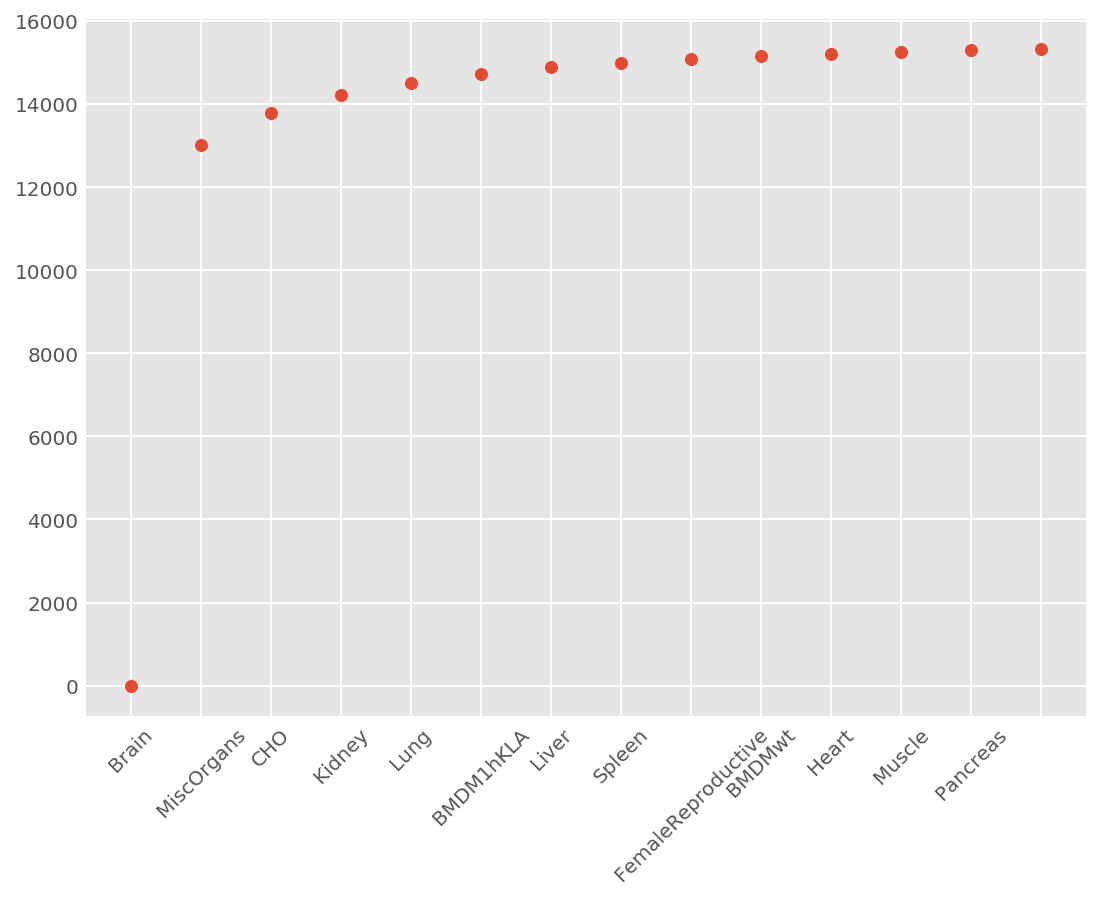

In [9]:
mrna_cum_peaks_n, mrna_cum_peaks = get_cum_and_plot(mrna_peaks, gene_tissues_order)
all_peaks_n['mRNA'] = mrna_cum_peaks_n
all_peaks['mRNA'] = mrna_peaks

# ATAC

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(278369, 15)
0
96103
96103
138138
193469
199779
244780
250046
262557
262557
278369
278369
278369


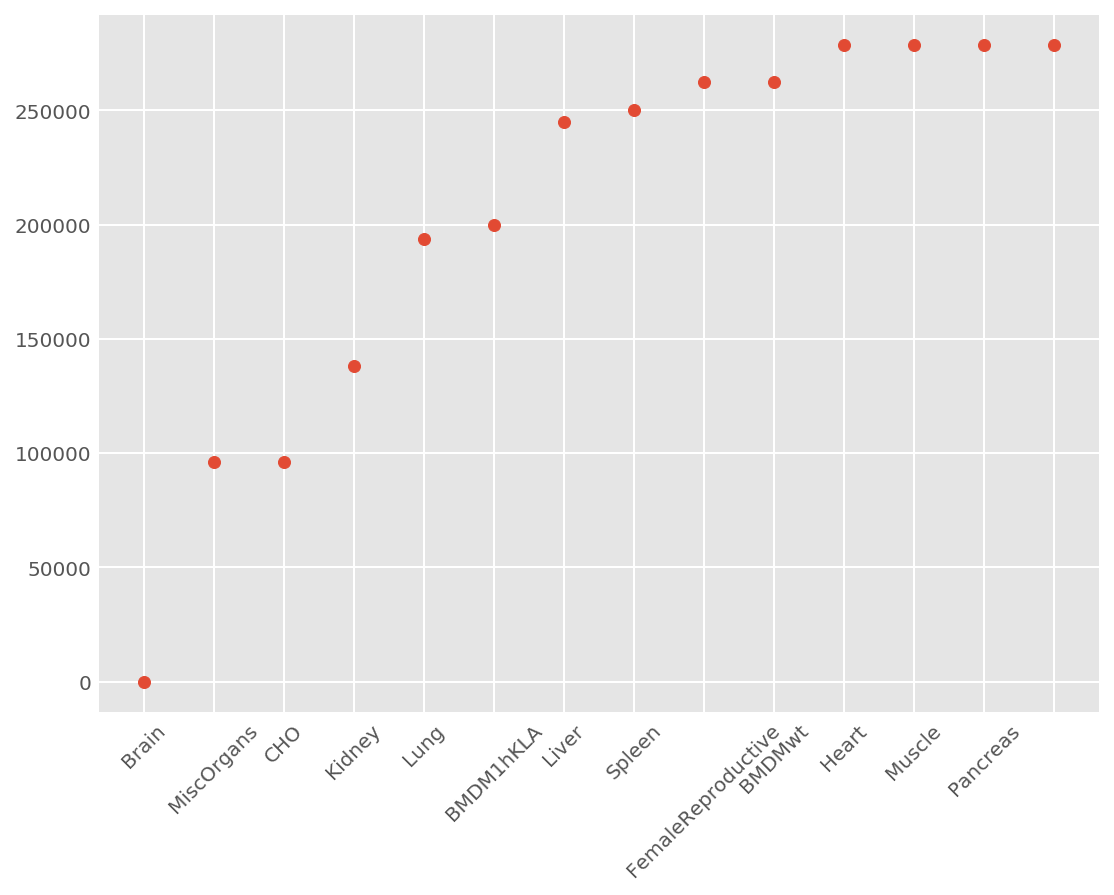

In [10]:
atac_merge = pd.read_csv("ATAC_Results/optimal_set/ATAC_merge.merge",sep="\t", index_col=0)
print(atac_merge.shape)

atac_peaks = {}
for t in gene_tissues_order:
    col = np.where(atac_merge.columns.str.contains(t))
    col = atac_merge.columns[col]
    if len(col) ==0:
        atac_peaks[t] = {}
    elif len(col) > 1:
        print("Too many samples", t)
        continue
    else:
        atac_peaks[t] = set(atac_merge[~(atac_merge[col[0]].isnull())].index.values)

atac_cum_peaks_n, atac_cum_peaks = get_cum_and_plot(atac_peaks, gene_tissues_order)
all_peaks_n['ATAC'] = atac_cum_peaks_n
all_peaks['ATAC'] = atac_peaks

## Enhancers:
1. Enhancer:  
   i. Annotation as intergenic  
   ii. Distance to TSS > 1000  
   iii. Need to handle same strand/divergent transcription  
2. Filter:  
   i. > 1 CPM  
   ii. > 10 CPM ??  
   iii. > 2 tissues  

In [11]:
intergenic = pd.read_csv("analysis_ncbi_picr/merged/samples.merge.anno",sep="\t",index_col=0)
#intergenic["Annotation"].filna(inplace=True)
intergenic = intergenic[(intergenic["Annotation"].str.contains("Intergenic") & (np.abs(intergenic["Distance to TSS"].fillna(0).astype(int)) > 1000))]

intergenic_expr_df = expr_df.loc[intergenic.index]
intergenic_expr_df

,Heart,Spleen,MiscOrgans,FemaleReproductive,CHO,BMDM1hKLA,Brain,Lung,Liver,BMDMwt,Muscle,Kidney,Pancreas
PeakID (cmd=annotatePeaks.pl Results/merged/samples.merge /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3),,,,,,,,,,,,,
21564,0.00,997.65,6353.05,1443.85,0.0000,0.0,0.000000,2013.210000,15855.566667,0.0,8095.50,5406.433333,992.90
91038,0.00,870.20,0.00,11888.75,0.0000,0.0,0.000000,0.000000,0.000000,0.0,4057.85,1970.233333,0.00
1060,1604.65,272.95,30360.10,255.05,1451.5130,0.0,5940.685714,322.700000,696.566667,0.0,538.00,406.766667,19401.65
167474,5278.55,1115.25,0.00,4907.40,0.0000,0.0,0.000000,0.000000,0.000000,0.0,1704.40,1951.233333,0.00
139598,1235.90,1242.95,2604.70,5534.45,2664.2000,1170.0,9684.214286,1524.033333,300.766667,2547.0,3039.90,2507.066667,4222.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
289272,0.00,0.00,0.00,0.00,0.0598,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.00
285035,0.00,0.00,0.00,0.00,0.0598,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.00
305615,0.00,0.00,0.00,0.00,0.1176,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.00


#### 1. Threshold = 10 (log10=1)
#### Distance to gene > 1000

0
7665
17622
36931
50207
56770
104348
119869
124690
129611
161167
169248
173168


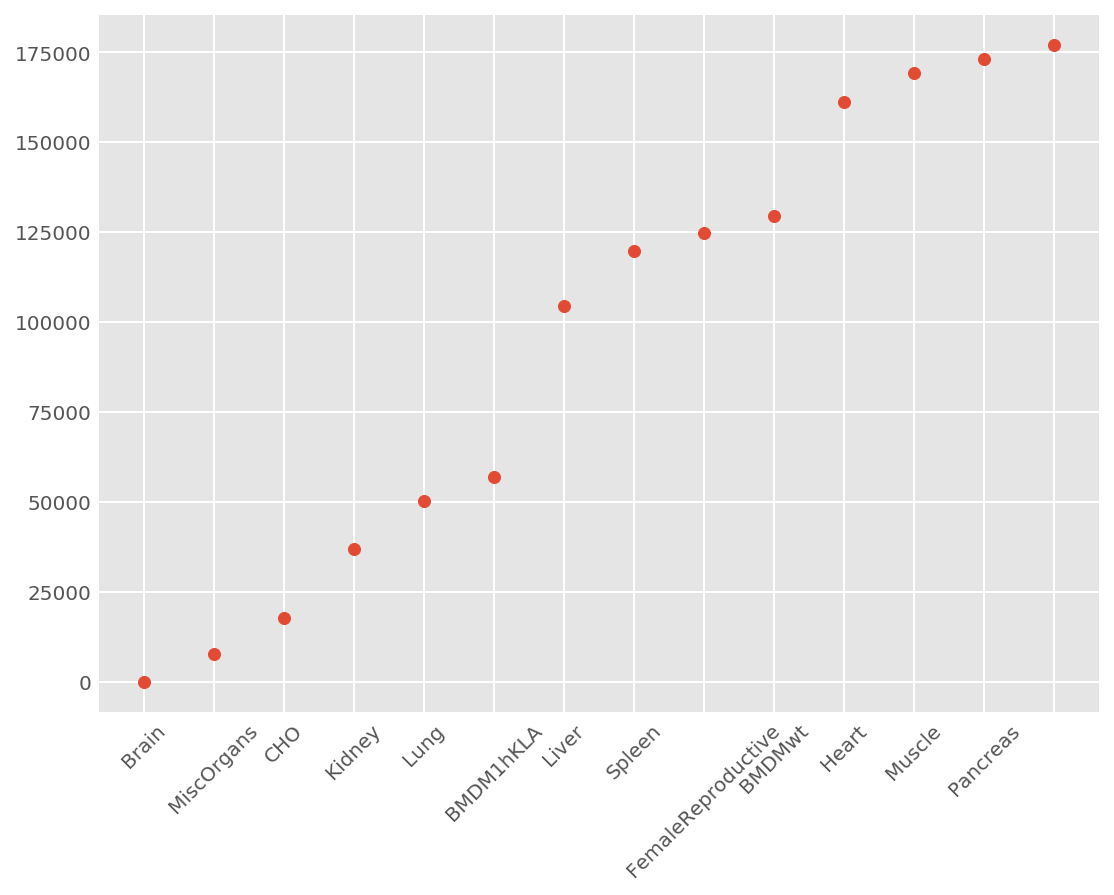

In [12]:
bin_df_enh = create_binary_from_expr(intergenic_expr_df,threshold=thresh)
#cdf_number,cdf_tissues = create_cdf(bin_df_enh)

distal_peaks = {}
for t in gene_tissues_order:    
    col = t
    distal_peaks[t] = set(bin_df_enh[~(bin_df_enh[col]==0)].index.values)

enh_cum_peaks_n, enh_cum_peaks = get_cum_and_plot(distal_peaks, gene_tissues_order);
all_peaks_n['Distal'] = enh_cum_peaks_n
all_peaks['Distal'] = distal_peaks

## ncRNA (annotated)

## Get information from annotation

In [13]:
anno_f = doc["alt_annotation"]
print(anno_f)
anno_df = pd.read_csv(anno_f,sep="\t", header=None,comment="#")
anno_types = anno_df[2].unique()
not_include = ['mRNA','gene', 'region','exon','CDS','primary_transcript','guide_RNA',
               'pseudogene','transcript','match','cDNA_match']
anno_types_keep = set(anno_types) - set(not_include)

print(anno_types_keep)
anno_df_otherrna = anno_df[anno_df[2].isin(anno_types_keep)]
print(anno_df_otherrna.shape)
anno_df_otherrna = generate_genome.expand_anno_id(anno_df_otherrna)
anno_df_otherrna


/data/isshamie/genome/hamster/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3


231it [00:00, 2309.21it/s]

{'lnc_RNA', 'snoRNA', 'snRNA', 'V_gene_segment', 'miRNA', 'tRNA', 'C_gene_segment', 'rRNA'}
(8767, 9)


8767it [00:02, 3935.46it/s]


,0,1,2,3,4,5,6,7,8,ID,...,product,transcript_id,Note,anticodon,inference,standard_name,exception,end_range,partial,start_range
4,NW_020822366.1,Gnomon,lnc_RNA,269294,313331,.,+,.,"ID=rna0;Parent=gene1;Dbxref=GeneID:113832197,G...",rna0,...,uncharacterized LOC113832197%2C transcript var...,XR_003479383.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NW_020822366.1,Gnomon,lnc_RNA,551299,551829,.,+,.,"ID=rna1;Parent=gene2;Dbxref=GeneID:113832198,G...",rna1,...,uncharacterized LOC113832198,XR_003479384.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NW_020822366.1,Gnomon,lnc_RNA,696459,713531,.,+,.,"ID=rna2;Parent=gene3;Dbxref=GeneID:103159926,G...",rna2,...,uncharacterized LOC103159926%2C transcript var...,XR_003479386.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NW_020822366.1,Gnomon,lnc_RNA,696459,713531,.,+,.,"ID=rna3;Parent=gene3;Dbxref=GeneID:103159926,G...",rna3,...,uncharacterized LOC103159926%2C transcript var...,XR_003479388.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,NW_020822366.1,Gnomon,lnc_RNA,710127,713531,.,+,.,"ID=rna4;Parent=gene3;Dbxref=GeneID:103159926,G...",rna4,...,uncharacterized LOC103159926%2C transcript var...,XR_003479385.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277584,NW_020824166.1,Gnomon,V_gene_segment,30244,32178,.,+,.,ID=id632731;Parent=gene32998;Dbxref=GeneID:113...,id632731,...,NaN,NaN,NaN,NaN,NaN,Ig heavy chain V region 3-6-like,NaN,NaN,NaN,NaN
1277593,NW_020824167.1,tRNAscan-SE,tRNA,20889,20960,.,+,.,ID=rna56292;Parent=gene32999;Dbxref=GeneID:107...,rna56292,...,tRNA-Ala,NaN,transfer RNA alanine (anticodon UGC),(pos:20921..20923),COORDINATES: profile:tRNAscan-SE:1.23,NaN,NaN,NaN,NaN,NaN
1277684,NW_020824187.1,Gnomon,V_gene_segment,13199,14646,.,-,.,ID=id632785;Parent=gene33011;Dbxref=GeneID:113...,id632785,...,NaN,NaN,NaN,NaN,NaN,Ig kappa chain V-II region 26-10-like,NaN,NaN,NaN,NaN
1277741,NW_020824193.1,Gnomon,V_gene_segment,12876,13513,.,+,.,ID=id632813;Parent=gene33016;Dbxref=GeneID:113...,id632813,...,NaN,NaN,NaN,NaN,NaN,Ig kappa chain V-III region MOPC 63-like,NaN,NaN,NaN,NaN


In [14]:
ncrnas = annoPeaks[annoPeaks['Annotation'].fillna('').str.contains("ncRNA")]
ncrnas_prom = ncrnas[(ncrnas["Annotation"].fillna('').str.contains("promoter"))]
ncrnas_prom_expression = expr_df.loc[ncrnas_prom.index]
print(f"Number of ncrnas: {ncrnas.shape[0]}")
ncrnas_prom_expression = expr_df.loc[ncrnas_prom.index]

ncrnas_prom = ncrnas_prom.dropna(axis=1,how='all')
ncrnas_prom = generate_genome.expand_anno_id(ncrnas_prom,colname='Nearest PromoterID')


gene_ID = dict()
for biotype, df in anno_df_otherrna.groupby(2):
    print(biotype)
    gene_ID[biotype] = df['ID'].values

peak_ID = dict()
for i in gene_ID:
    print(i)
    print(f"Number of the type: {len(gene_ID[i])}")
    print('Parent')
    print(ncrnas_prom['Parent'].isin(gene_ID[i]).sum())

    peak_ID[i] = ncrnas_prom[ncrnas_prom['Parent'].isin(gene_ID[i])].index

peak_ID

265it [00:00, 2645.20it/s]

Number of ncrnas: 13102


7862it [00:01, 4374.79it/s]


C_gene_segment
V_gene_segment
lnc_RNA
miRNA
rRNA
snRNA
snoRNA
tRNA
C_gene_segment
Number of the type: 9
Parent
0
V_gene_segment
Number of the type: 592
Parent
0
lnc_RNA
Number of the type: 5891
Parent
5959
miRNA
Number of the type: 291
Parent
53
rRNA
Number of the type: 22
Parent
0
snRNA
Number of the type: 871
Parent
466
snoRNA
Number of the type: 606
Parent
219
tRNA
Number of the type: 485
Parent
20


{'C_gene_segment': Int64Index([], dtype='int64', name='PeakID (cmd=annotatePeaks.pl Results/merged/samples.merge /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3)'),
 'V_gene_segment': Int64Index([], dtype='int64', name='PeakID (cmd=annotatePeaks.pl Results/merged/samples.merge /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3)'),
 'lnc_RNA': Int64Index([484565, 129410, 195062,  88219, 450911, 113553,   6896, 346530,
             146151, 276873,
             ...
             428483, 428439, 428957, 429708, 428485, 429921, 429335, 343309,
             344967, 429753],
            dtype='int64', name='PeakID (cmd=annotatePeaks.pl Results/merged/samples.merge /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_l

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
593
876
1963
2257
2412
2900
3221
3329
3382
3684
3799
3867
0
4
4
6
17
17
18
24
24
24
31
41
42
0
0
0
0
0
0
0
0
0
0
0
0
0
0
112
121
168
225
233
269
283
291
312
330
339
341
0
48
49
60
70
77
95
107
111
118
149
157
160
0
2
3
10
10
12
14
15
16
17
18
18
18


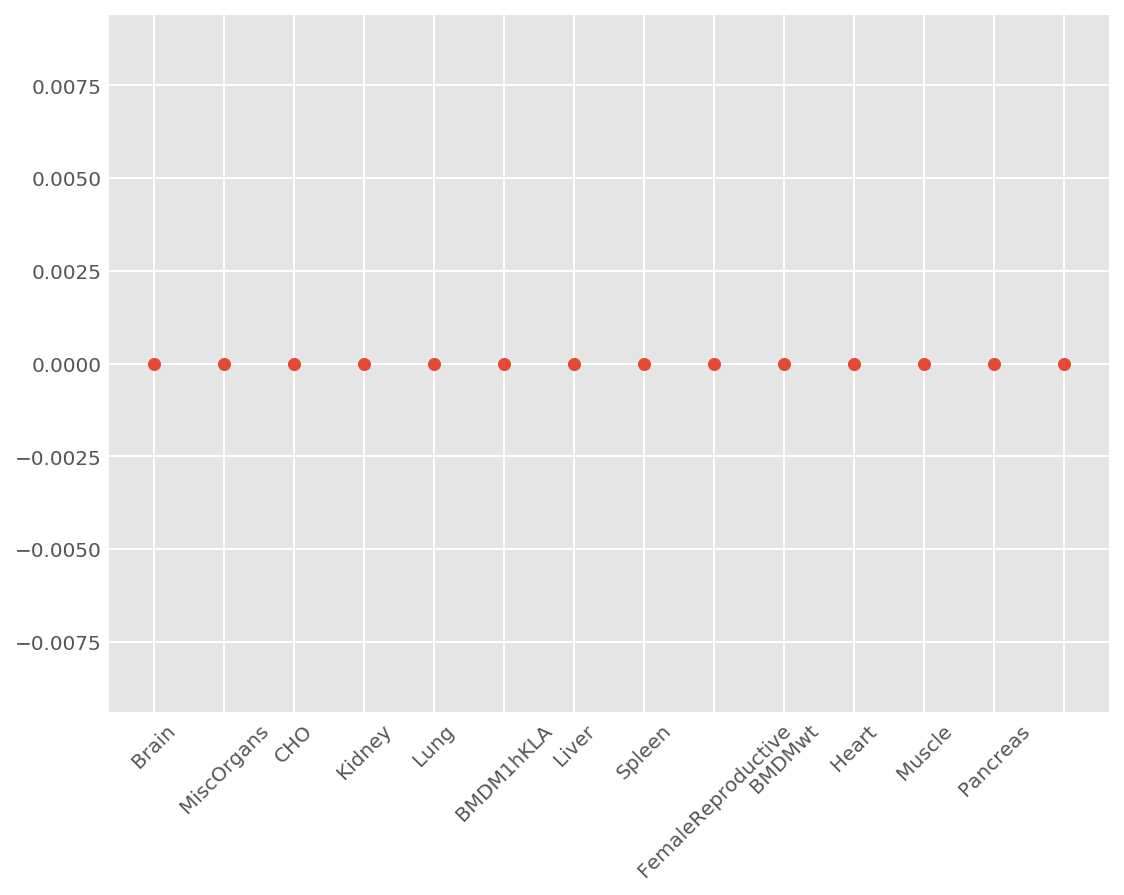

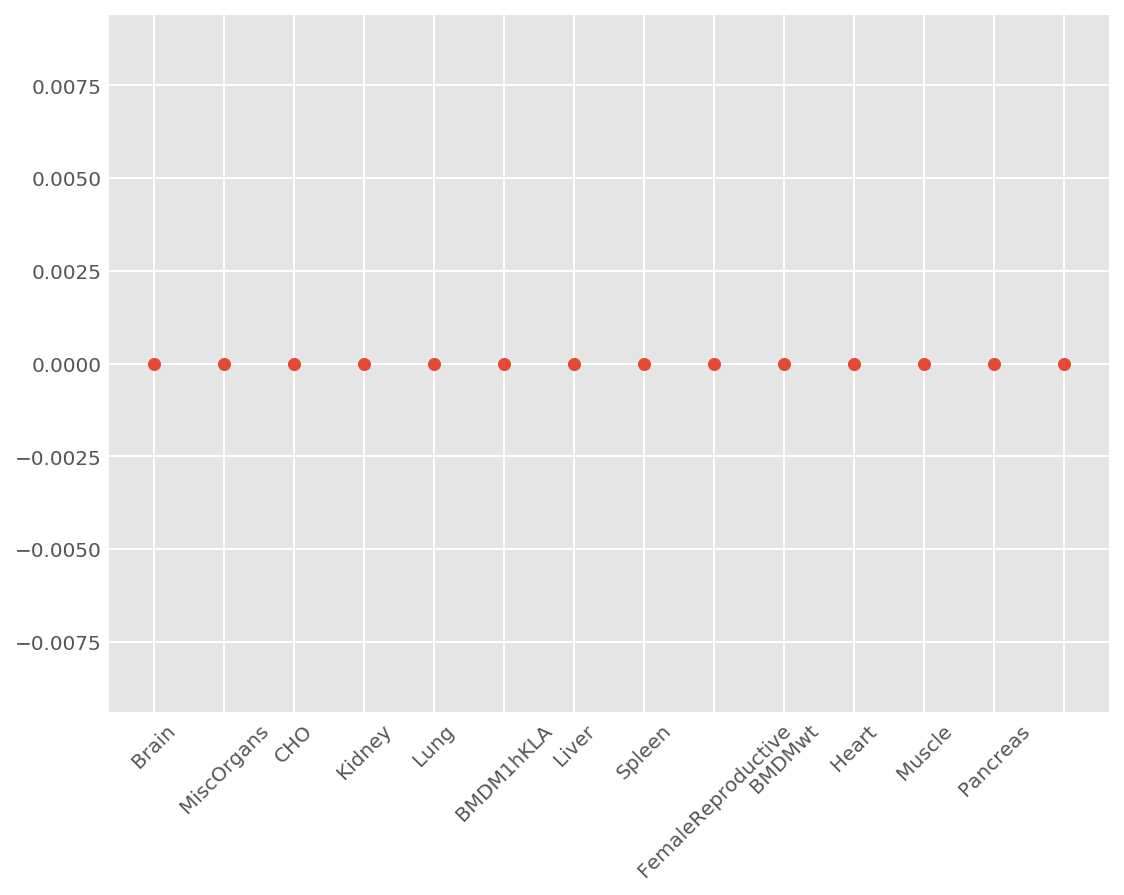

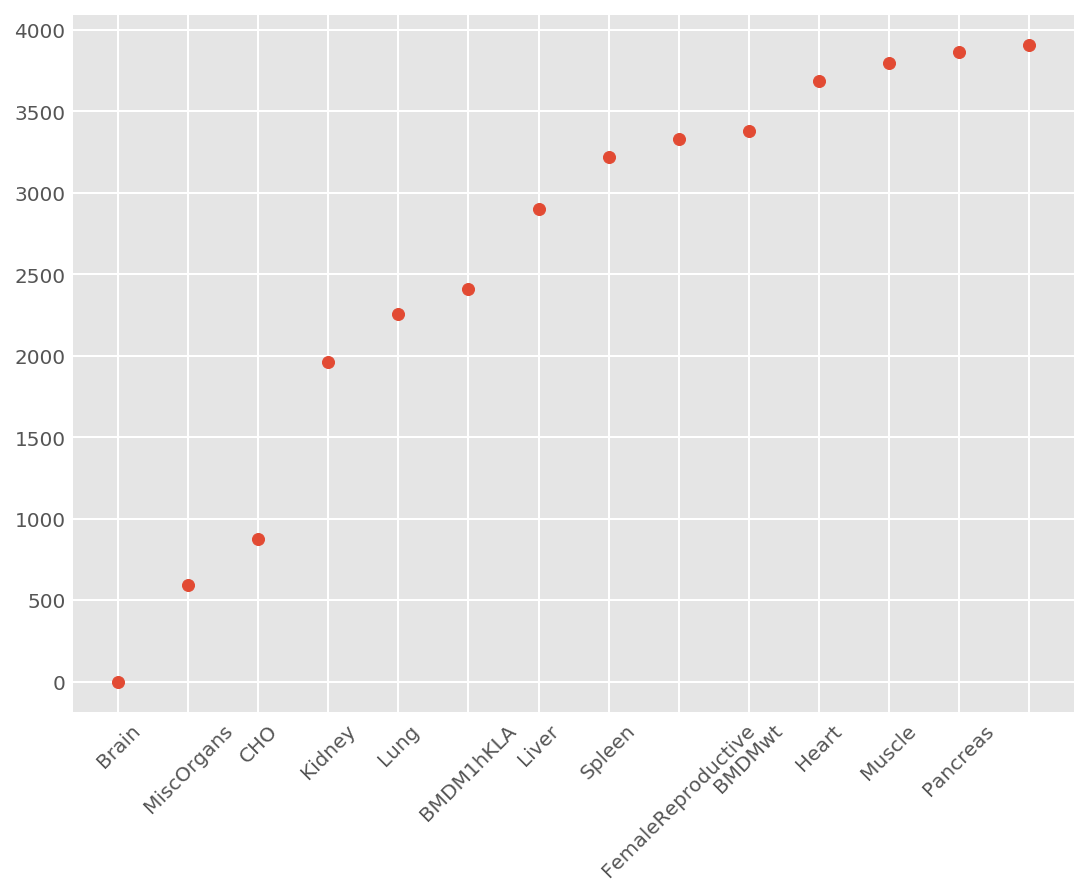

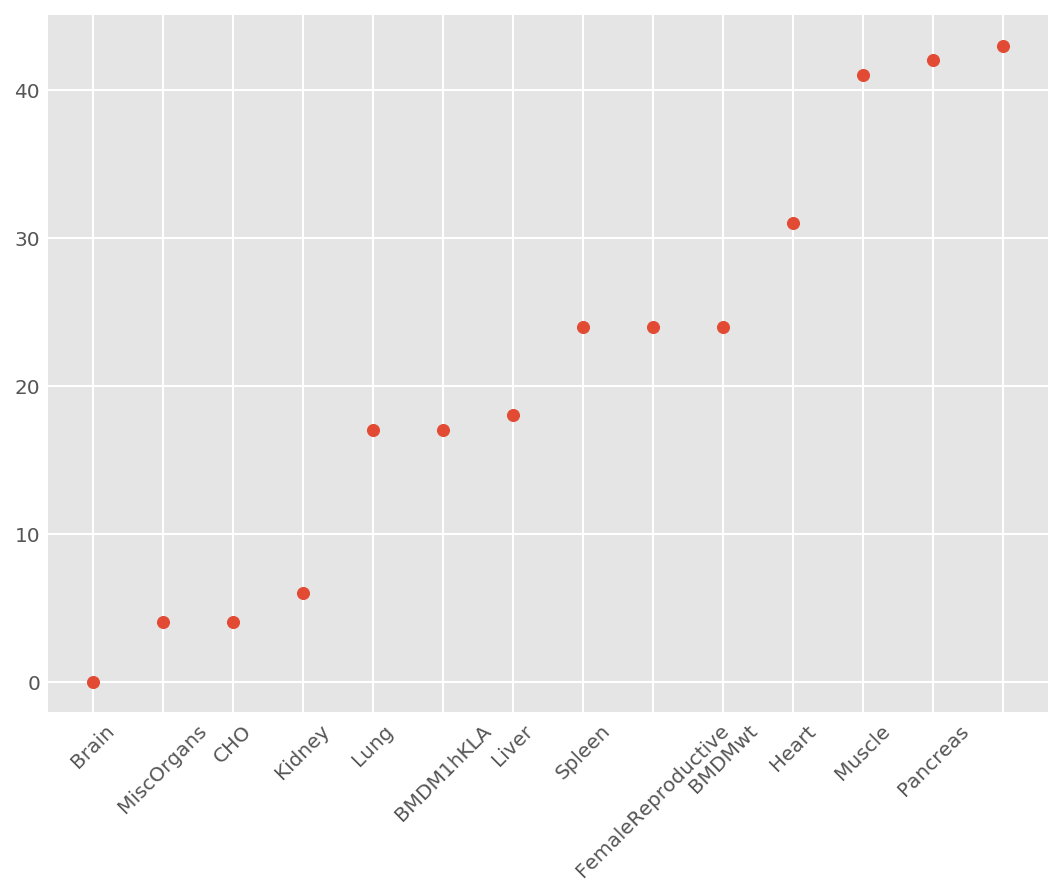

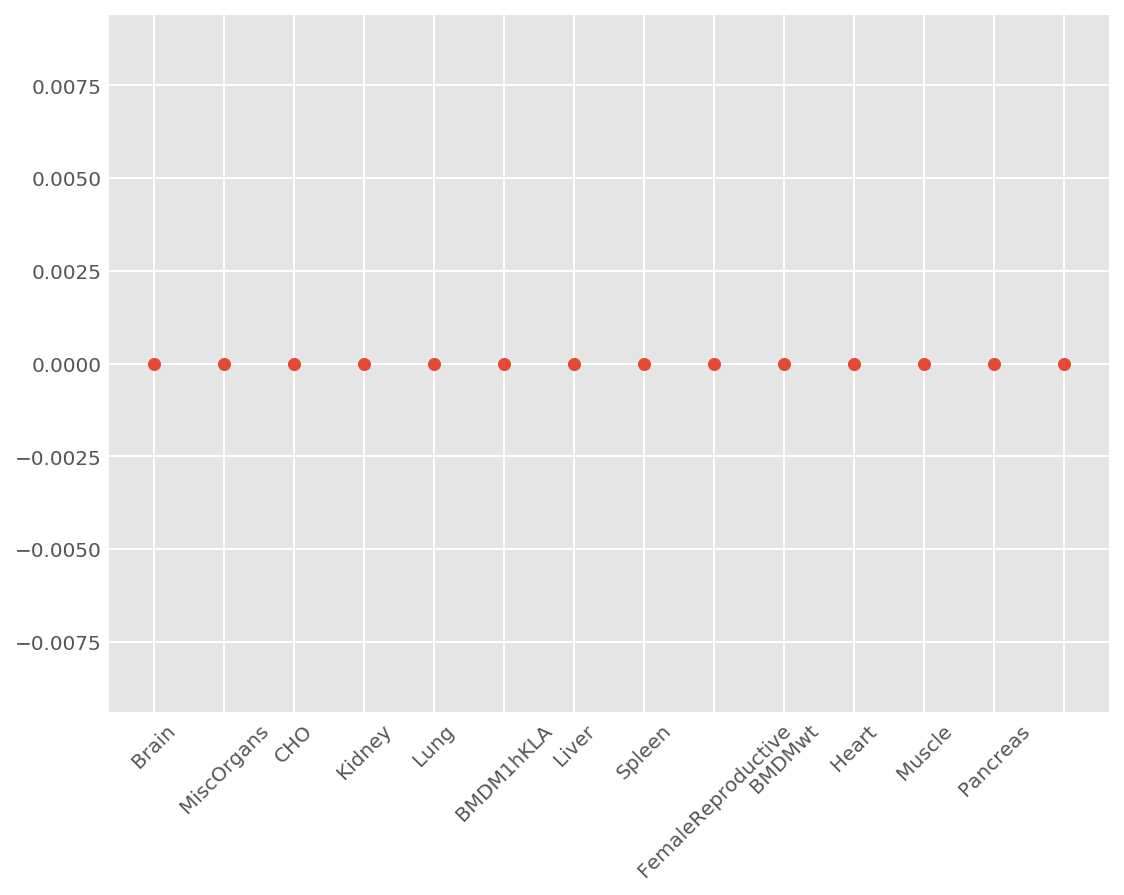

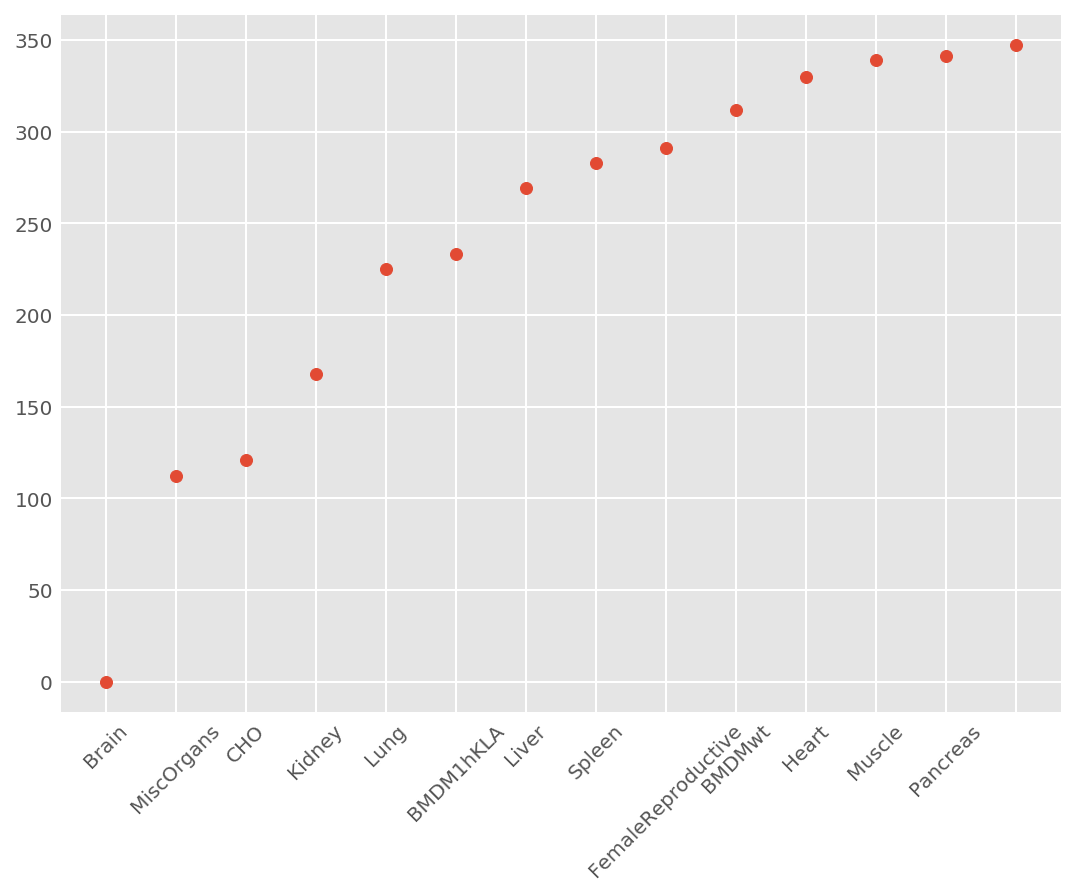

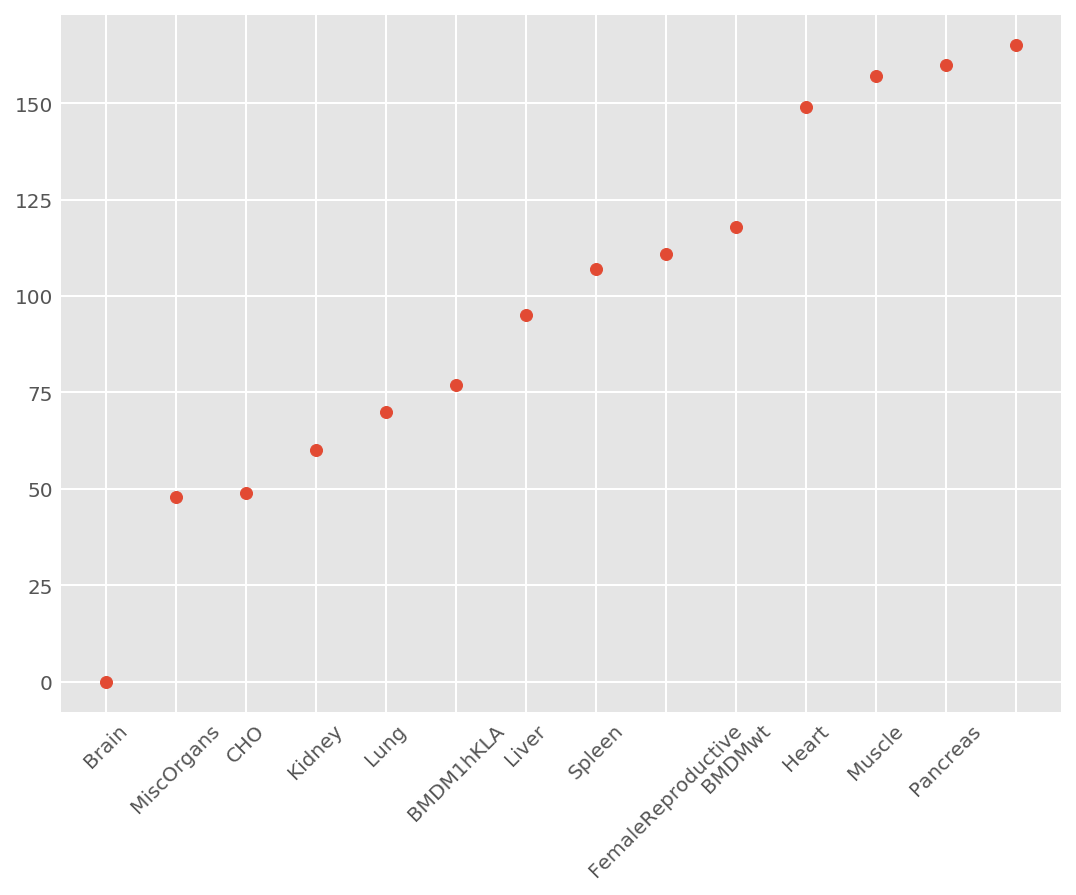

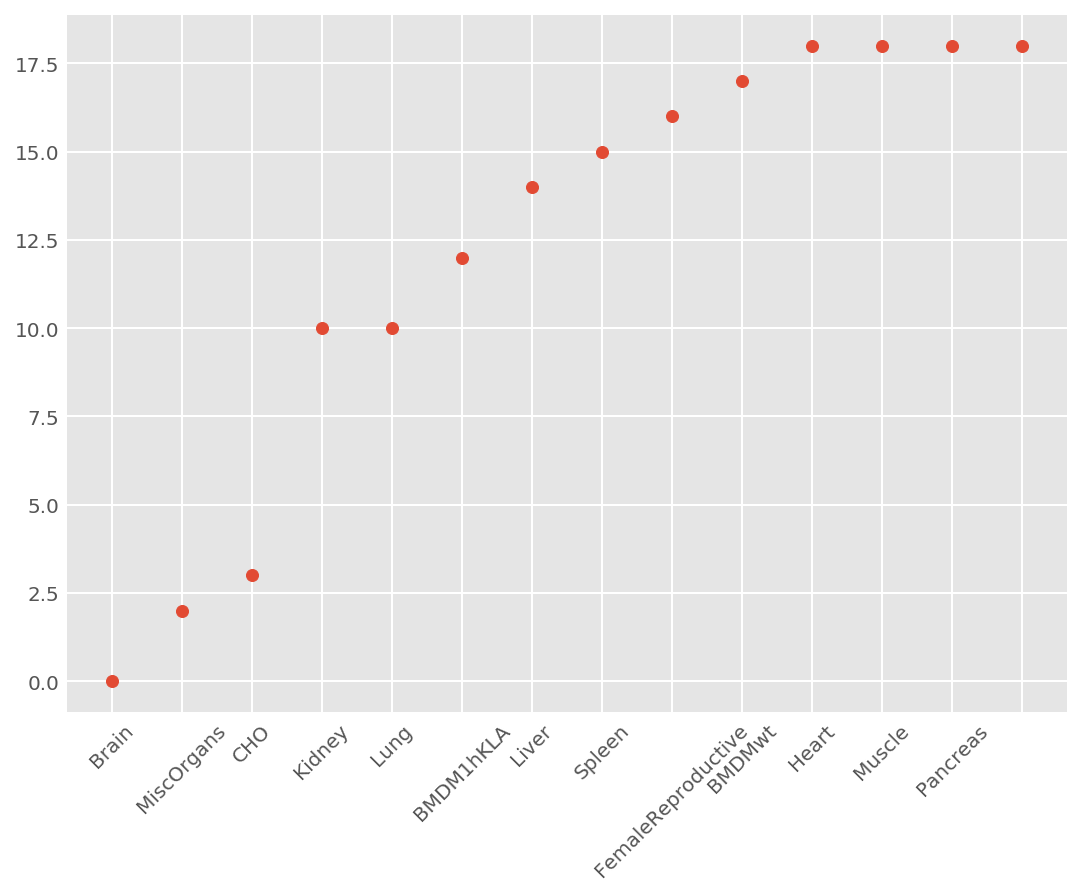

In [15]:
biotype_cum_peaks_n = dict()

for i in peak_ID:
    curr_bin_df = create_binary_from_expr(expr_df.loc[peak_ID[i]],threshold=thresh)

    # Tissue peaks
    curr_tissue_peaks = {}
    for t in gene_tissues_order:    
        col = t
        curr_tissue_peaks[t] = set(curr_bin_df[~(curr_bin_df[col]==0)].index.values)
    
    
    curr_cum_peaks_n, curr_cum_peaks = get_cum_and_plot(curr_tissue_peaks, gene_tissues_order);
    biotype_cum_peaks_n[i] = curr_cum_peaks_n
    all_peaks_n[i] = curr_cum_peaks_n
    all_peaks[i] = curr_tissue_peaks

In [16]:
biotype_cum_peaks_n

{'C_gene_segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'V_gene_segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'lnc_RNA': [0,
  593,
  876,
  1963,
  2257,
  2412,
  2900,
  3221,
  3329,
  3382,
  3684,
  3799,
  3867,
  3905],
 'miRNA': [0, 4, 4, 6, 17, 17, 18, 24, 24, 24, 31, 41, 42, 43],
 'rRNA': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'snRNA': [0, 112, 121, 168, 225, 233, 269, 283, 291, 312, 330, 339, 341, 347],
 'snoRNA': [0, 48, 49, 60, 70, 77, 95, 107, 111, 118, 149, 157, 160, 165],
 'tRNA': [0, 2, 3, 10, 10, 12, 14, 15, 16, 17, 18, 18, 18, 18]}

-------

-------

# A. Create df of cumulative numbers where rows are peak type and column is the order

In [17]:
all_peaks["mRNA"] = mrna_peaks
all_peaks["ATAC"] = atac_peaks
all_peaks["Distal"] = distal_peaks

In [18]:
df = pd.DataFrame(all_peaks_n, index=["None"] + gene_tissues_order).transpose()
print(f"RNA with nothing seen: {df.index[((df==0).all(axis=1))]}")
df = df[~((df==0).all(axis=1))]
df.to_csv(cumulative_f)

df.loc['All'] = df.sum()
df

RNA with nothing seen: Index(['C_gene_segment', 'V_gene_segment', 'rRNA'], dtype='object')


,None,Brain,MiscOrgans,CHO,Kidney,Lung,BMDM1hKLA,Liver,Spleen,FemaleReproductive,BMDMwt,Heart,Muscle,Pancreas
mRNA,0,13017,13787,14211,14508,14736,14888,14991,15079,15152,15216,15258,15294,15317
ATAC,0,96103,96103,138138,193469,199779,244780,250046,262557,262557,278369,278369,278369,278369
Distal,0,7665,17622,36931,50207,56770,104348,119869,124690,129611,161167,169248,173168,176914
lnc_RNA,0,593,876,1963,2257,2412,2900,3221,3329,3382,3684,3799,3867,3905
miRNA,0,4,4,6,17,17,18,24,24,24,31,41,42,43
snRNA,0,112,121,168,225,233,269,283,291,312,330,339,341,347
snoRNA,0,48,49,60,70,77,95,107,111,118,149,157,160,165
tRNA,0,2,3,10,10,12,14,15,16,17,18,18,18,18
All,0,117544,128565,191487,260763,274036,367312,388556,406097,411173,458964,467229,471259,475078


In [19]:
colors, name_dict = get_colors(scheme='categorical',n_colors=len(df.index),names=df.index.values )
colors

Generating palette: 100% |######################################| Time: 0:00:09


{'lnc_RNA': array([8.43137255e-01, 7.17204074e-16, 0.00000000e+00]),
 'Distal': array([0.54901961, 0.23529412, 1.        ]),
 'snoRNA': array([7.84313725e-03, 5.33333333e-01, 1.55767760e-15]),
 'snRNA': array([2.00817141e-14, 6.74509804e-01, 7.80392157e-01]),
 'mRNA': array([5.96078431e-01, 1.00000000e+00, 4.93077801e-16]),
 'All': array([1.        , 0.49803922, 0.81960784]),
 'miRNA': array([4.23529412e-01, 8.96505092e-16, 3.09803922e-01]),
 'ATAC': array([1.        , 0.64705882, 0.18823529]),
 'tRNA': array([0.00000000e+00, 5.37903055e-16, 6.15686275e-01])}

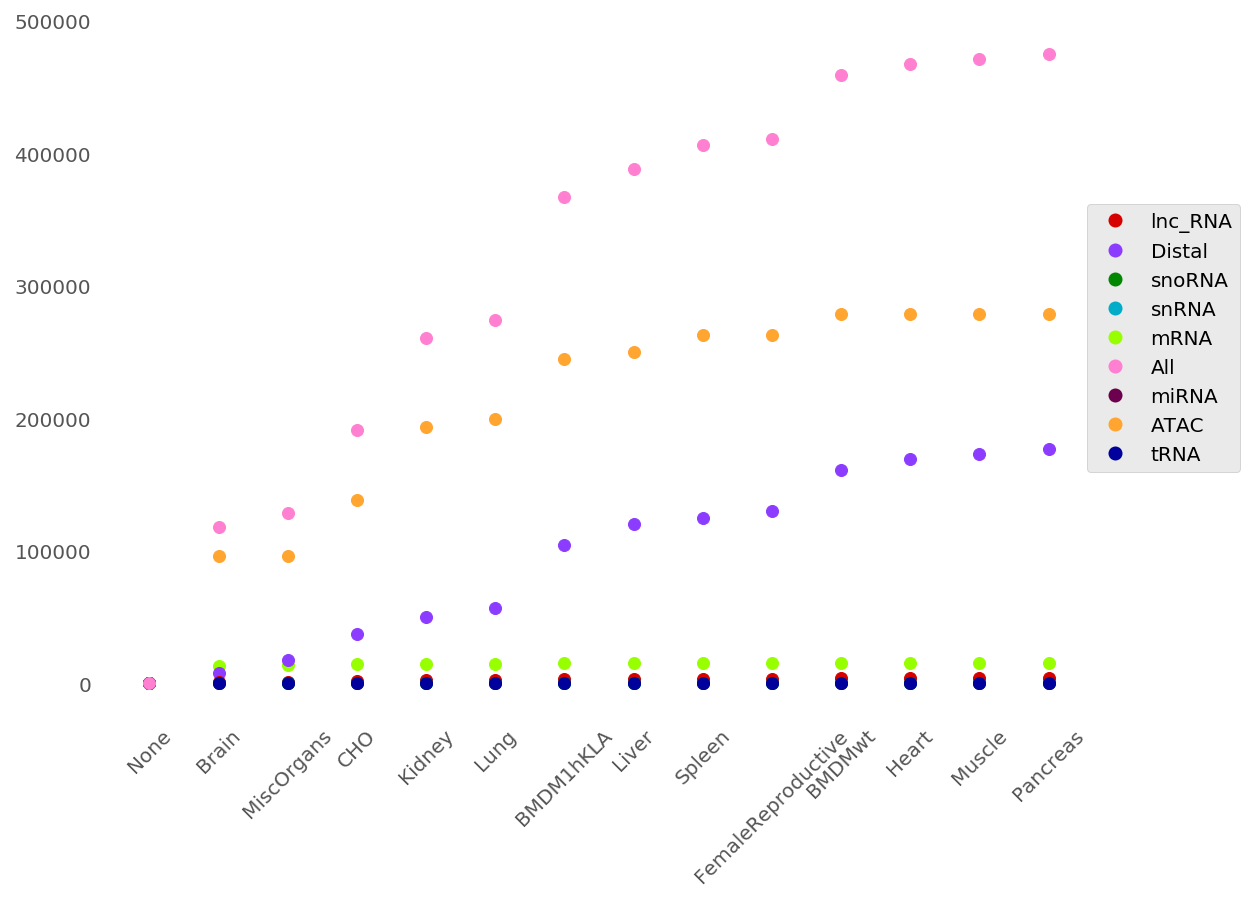

In [20]:
f, ax = plt.subplots()
for ind, val in df.iterrows():
    plot_cum(val.values, df.columns,f_save=None, ax=ax, c=np.array([colors[ind],]))
    #plt.scatter(np.arange(len(val.values)val.values)
legend_from_color(colors, curr_ax = ax)
helper_save(cumulative_f)

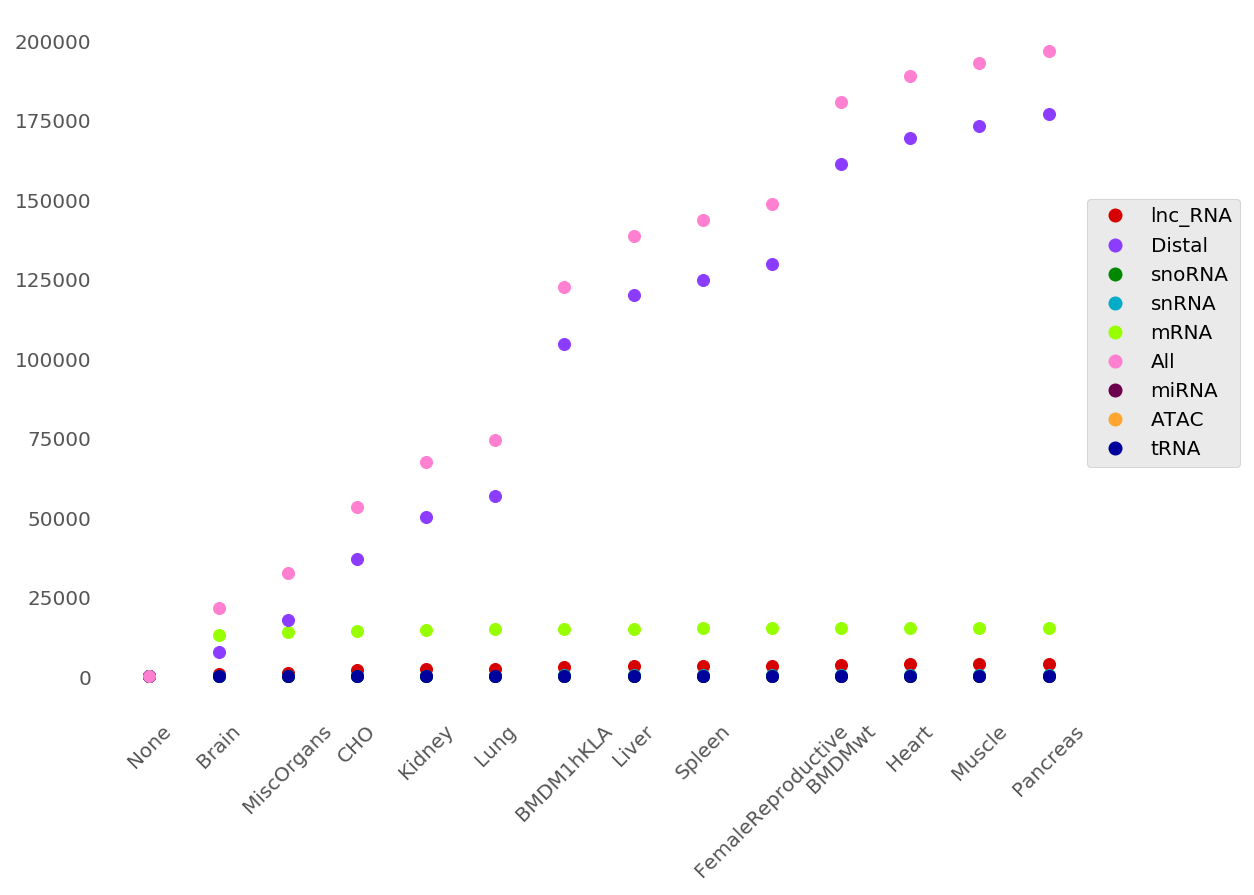

In [21]:
f, ax = plt.subplots()

df.loc['All'] =  df.drop(['ATAC','All']).sum()
for ind, val in df.drop(['ATAC']).iterrows():
    if ind == 'ATAC':
        continue

    plot_cum(val.values, df.columns,f_save=None, ax=ax, c=np.array([colors[ind],]))
    #plt.scatter(np.arange(len(val.values)val.values)
legend_from_color(colors, curr_ax = ax)
helper_save(cumulative_f+'.noATAC')

## B. Venn Diagram Between CHO and other

In [22]:
def get_venn(peaks, group_A_list, group_B_list):
    group_A_peaks = set()
    for i in group_A_list:
        group_A_peaks = group_A_peaks.union(peaks[i])

    group_B_peaks = set()
    for i in group_B_list:
        group_B_peaks = group_B_peaks.union(peaks[i])
        
    # Venn Diagram
    a = group_A_peaks - group_B_peaks
    b = group_B_peaks - group_A_peaks
    overlap = group_B_peaks.intersection(group_A_peaks)
    return a, b, overlap

In [24]:
#venn = pd.DataFrame(index=["mRNA", "Distal", "ATAC"], columns=["CHO","Tissues", "Overlap"])
venn = pd.DataFrame(index=list(all_peaks.keys()), columns=["CHO","Tissues", "Overlap"])
venn = venn.loc[df.drop('All').index]

cho = ["CHO"]
tissues_group = list(filter(lambda x: x != "CHO", tissues))
for ind, val in venn.iterrows():
    a, b, overlap = get_venn(all_peaks[ind], cho, tissues_group)
    venn.at[ind,"CHO"] = a
    venn.at[ind,"Tissues"] = b
    venn.at[ind,"Overlap"] = overlap
    
venn_n = venn.applymap(lambda x: len(x), )
venn_n.to_csv(venn_f)
venn_n

,CHO,Tissues,Overlap
mRNA,198,5464,9655
ATAC,26035,207716,44618
Distal,14982,154736,7196
lnc_RNA,770,2402,733
miRNA,1,41,1
snRNA,22,249,76
snoRNA,6,144,15
tRNA,3,10,5


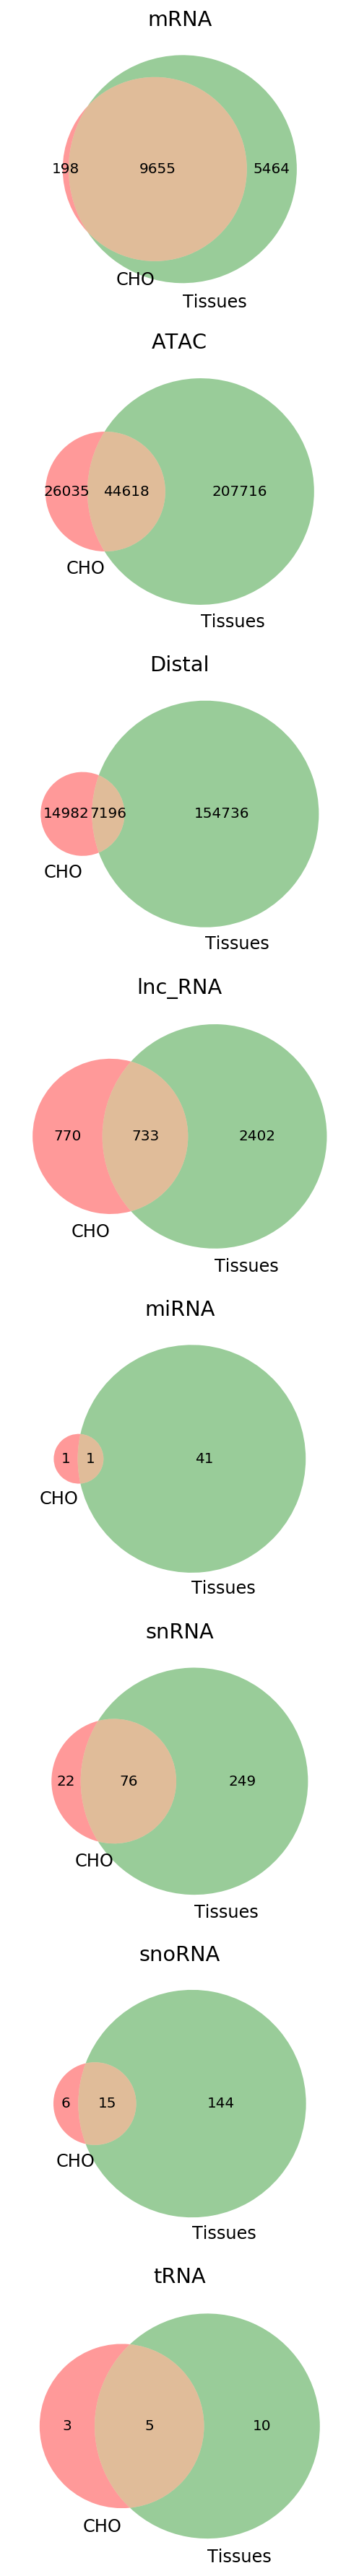

In [25]:
f, ax = plt.subplots(nrows=venn_n.shape[0],figsize=(30,30))

count=0
for ind, val in venn_n.iterrows():
    venn2(subsets=(val["CHO"], val["Tissues"], val["Overlap"]),set_labels=('CHO','Tissues'), ax=ax[count])
    ax[count].set_title(ind)
    count += 1

helper_save(venn_f)
